In [48]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import ast
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity,linear_kernel
from surprise import Reader, Dataset, SVD, SVDpp, NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, NMF, SlopeOne, KNNBaseline, KNNWithZScore, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

# To create plots
import matplotlib.pyplot as plt

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [49]:
df_songs = pd.read_csv("/kaggle/input/song-recommendation-dataset/spotify_songs.csv", index_col=[0])
df_songs.head()

,song_id,Title,Artist,Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Duration (ms),Valence,Year
0,1,Beggin',Måneskin,"['indie rock italiano', 'italian pop']",100,0.714,0.8,-4.808,0.0504,0.127,0.359,211560,0.589,2017.0
1,2,STAY (with Justin Bieber),The Kid LAROI,['australian hip hop'],99,0.591,0.764,-5.484,0.0483,0.0383,0.103,141806,0.478,2021.0
2,3,good 4 u,Olivia Rodrigo,['pop'],99,0.563,0.664,-5.044,0.154,0.335,0.0849,178147,0.688,2021.0
3,4,Bad Habits,Ed Sheeran,"['pop', 'uk pop']",98,0.808,0.897,-3.712,0.0348,0.0469,0.364,231041,0.591,2021.0
4,5,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,212000,0.894,2021.0


In [50]:
df_users = pd.read_csv("/kaggle/input/song-recommendation-dataset/users.csv", index_col=[0])
df_users.head()

,user_id,user_name,city,country,age,occupation,sex
0,U001,Douglas Baker,Joseside,Heard Island and McDonald Islands,35,"Scientist, audiological",M
1,U002,Patricia Rodriguez,East Cynthiamouth,Palau,40,Market researcher,M
2,U003,Danielle Perez,Molinaborough,Barbados,24,"Engineer, materials",F
3,U004,Stephanie Smith,Frederickshire,Nepal,30,"Therapist, music",NaN
4,U005,Samantha Callahan,Simsview,Sudan,38,"Lecturer, further education",M


In [51]:
df_query = pd.read_csv("/kaggle/input/song-recommendation-dataset/query.csv", index_col=[0])
df_query.head()

,query_id,cond_01,cond_02,cond_03
1,Q0002,age=35,NaN,NaN
3,Q0004,country=Heard Island and McDonald Islands,genre=tropical house,NaN
4,Q0005,age=35,genre=hip hop,NaN
5,Q0006,country=Heard Island and McDonald Islands,age=35,NaN
6,Q0007,country=Heard Island and McDonald Islands,age=35,genre=modern rock


In [52]:
df_query_ratings = pd.read_csv("/kaggle/input/song-recommendation-dataset/query_ratings.csv", index_col=[0])
df_query_ratings.head()

,user_id,query_id,rating
3,U064,Q0544,47
4,U078,Q0286,42
6,U084,Q0271,71
7,U059,Q0412,21
11,U084,Q0475,56


In [53]:
# matrix=pd.pivot_table(data=df_users, values='rating', index='user_id',columns='query_id')

In [54]:
query_rating_pivot = df_query_ratings.pivot_table(index = 'user_id', columns = 'query_id', values = 'rating', aggfunc='first').fillna(0)
query_rating_pivot.head(10)

query_id,Q0002,Q0004,Q0005,Q0006,Q0007,Q0008,Q0011,Q0012,Q0013,Q0014,...,Q0686,Q0688,Q0690,Q0691,Q0692,Q0693,Q0694,Q0697,Q0699,Q0700
user_id,,,,,,,,,,,,,,,,,,,,,
U001,0.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,8.0,0.0,63.0,73.0,0.0,0.0,35.0,43.0
U002,51.0,75.0,0.0,0.0,0.0,22.0,0.0,80.0,0.0,0.0,...,81.0,0.0,0.0,40.0,0.0,0.0,0.0,63.0,49.0,0.0
U003,0.0,0.0,7.0,18.0,0.0,0.0,0.0,72.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,1.0,51.0
U004,0.0,39.0,41.0,0.0,41.0,0.0,95.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,14.0,0.0
U005,0.0,58.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,94.0,...,31.0,0.0,11.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
U006,0.0,0.0,0.0,62.0,97.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,45.0,0.0
U007,14.0,0.0,0.0,77.0,15.0,62.0,0.0,0.0,10.0,0.0,...,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,33.0,20.0
U008,58.0,0.0,77.0,90.0,0.0,60.0,93.0,0.0,11.0,21.0,...,0.0,0.0,84.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0
U009,0.0,14.0,0.0,14.0,0.0,0.0,0.0,0.0,92.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0


In [55]:
reader = Reader(rating_scale=(1, 100))
data = Dataset.load_from_df(df_query_ratings[['user_id', 'query_id', 'rating']], reader)

In [56]:
svd = SVD()
results = cross_validate(svd, data, measures=['rmse'], cv=5, return_train_measures=True)


tmp = pd.DataFrame.from_dict(results).mean(axis=0)
rmse_svd = tmp['test_rmse']

In [57]:
n = 453
rating_matrix = []
for index, row in query_rating_pivot.iterrows():
#     utility_matrix[index] = row.reshape((2,1))
    # return the mean
    # skip all the missing values
    
#     row = row.replace(0, np.NaN)
    row_mean = row.mean(skipna = True)
    for i, v in row.items():
        if v == 0:
            col_mean = query_rating_pivot[i].mean(skipna = True)
            rmse_cb = math.sqrt(abs(row_mean - col_mean)/n)
#             print()
            if rmse_cb > 100:
                rmse_cb = 100
    #         print('index: ', i, 'value: ', v)
            rmse_final = (abs(1 - rmse_svd)) + (abs(1 - rmse_cb) * (row_mean + col_mean))
            rating_matrix.append([index, i, rmse_final])
        else:
            rating_matrix.append([index, i, v])
rating_matrix_df = pd.DataFrame(rating_matrix, columns=['user_id', 'query_id', 'rating'])

In [58]:
# rating_matrix = []
# for index, row in query_rating_pivot.iterrows():
# #     utility_matrix[index] = row.reshape((2,1))
#     # return the mean
#     # skip all the missing values
    
#     row = row.replace(0, np.NaN)
#     mean = row.mean(skipna = True)
#     for i, v in row.items():
# #         print('index: ', i, 'value: ', v)
#         rating_matrix.append([index, i, mean])

# rating_matrix_df = pd.DataFrame(rating_matrix, columns=['user_id', 'query_id', 'rating'])
# # rating_matrix

In [59]:
utility_rating_matrix = rating_matrix_df.pivot_table(index = 'user_id', columns = 'query_id', values = 'rating', aggfunc='first').fillna(0)
utility_rating_matrix.head(10)

query_id,Q0002,Q0004,Q0005,Q0006,Q0007,Q0008,Q0011,Q0012,Q0013,Q0014,...,Q0686,Q0688,Q0690,Q0691,Q0692,Q0693,Q0694,Q0697,Q0699,Q0700
user_id,,,,,,,,,,,,,,,,,,,,,
U001,64.991912,66.089209,60.000000,64.873722,66.792526,64.930580,65.746316,1.000000,64.697543,65.713802,...,65.246436,56.968616,8.000000,61.150960,63.000000,73.000000,65.997372,65.113812,35.000000,43.000000
U002,51.000000,75.000000,68.982929,64.900441,68.047861,22.000000,67.106142,80.000000,65.437988,67.078589,...,81.000000,57.564050,63.458818,40.000000,66.548447,66.871122,67.323861,63.000000,49.000000,60.441963
U003,64.968803,69.119617,7.000000,18.000000,69.649550,68.518541,68.913633,72.000000,65.626217,68.897480,...,68.823875,58.288171,63.931576,62.194772,67.671737,68.806653,51.000000,68.962071,1.000000,51.000000
U004,65.008535,39.000000,41.000000,65.231968,41.000000,68.448818,95.000000,13.000000,65.659295,69.074265,...,69.055502,58.353193,63.978882,62.250272,67.659594,69.001850,69.224669,79.000000,14.000000,61.147703
U005,64.612069,58.000000,5.000000,64.893054,67.831002,66.248209,66.868638,3.000000,65.469302,94.000000,...,31.000000,57.462747,11.000000,61.517588,2.000000,66.622969,67.093102,66.355262,67.995573,60.353520
U006,64.665930,67.661248,69.212924,62.000000,97.000000,66.888195,67.372758,66.912789,65.431383,67.346445,...,67.006525,57.676245,63.523529,70.000000,66.946213,67.150859,67.582328,66.935034,45.000000,60.540594
U007,14.000000,70.757124,71.847032,77.000000,15.000000,62.000000,70.743589,69.032167,10.000000,70.756500,...,70.025303,58.907001,67.000000,62.731608,67.763741,71.171174,70.735052,69.307162,33.000000,20.000000
U008,58.000000,68.825852,77.000000,90.000000,69.378746,60.000000,93.000000,68.547201,11.000000,21.000000,...,68.428024,58.168969,84.000000,62.093685,67.722371,68.461256,52.000000,68.484179,69.525266,60.980744
U009,64.695981,14.000000,69.380152,14.000000,68.466163,67.151199,67.568158,67.150020,92.000000,67.542829,...,67.224907,57.757397,63.572765,61.752419,67.269503,67.356776,67.771326,67.165522,79.000000,60.612346


In [60]:
# ## get recommendations for user '2'

rr = rating_matrix_df[rating_matrix_df['user_id']=='U040'].sort_values(by='rating', ascending=False)
rr.head(5)

,user_id,query_id,rating
17881,U040,Q0327,100.0
18020,U040,Q0544,100.0
17902,U040,Q0362,100.0
17712,U040,Q0070,99.0
17945,U040,Q0427,99.0


In [61]:
items = df_query_ratings['query_id'].unique()
test = [['U009', iid, 4] for iid in items]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

pred = pred.sort_values(by='est', ascending=False)
pred.rename(columns={'uid':'user_id', 'iid':'query_id', 'est':'rating'},inplace=True)
pred = pred[['user_id', 'query_id', 'rating', 'details']]
pred.head(5)

,user_id,query_id,rating,details
123,U009,Q0153,99.916305,{'was_impossible': False}
7,U009,Q0502,99.039825,{'was_impossible': False}
326,U009,Q0258,98.015944,{'was_impossible': False}
259,U009,Q0291,98.010281,{'was_impossible': False}
163,U009,Q0077,97.962918,{'was_impossible': False}


In [62]:
items = rating_matrix_df['query_id'].unique()
test = [['U040', iid, 4] for iid in items]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

pred = pred.sort_values(by='est', ascending=False)
pred.head(5)

,uid,iid,r_ui,est,details
235,U040,Q0362,4,100.000000,{'was_impossible': False}
214,U040,Q0327,4,99.792595,{'was_impossible': False}
45,U040,Q0070,4,99.051471,{'was_impossible': False}
278,U040,Q0427,4,99.020587,{'was_impossible': False}
128,U040,Q0193,4,97.999936,{'was_impossible': False}


In [63]:
reader = Reader(rating_scale=(1, 100))
data = Dataset.load_from_df(rating_matrix_df[['user_id', 'query_id', 'rating']], reader)

In [64]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,19.067958,13.148198,0.103008,0.072833
SlopeOne,19.099931,13.163545,0.509362,3.213199
KNNWithMeans,19.195993,13.336565,0.074317,1.854275
KNNBasic,19.205075,13.233825,0.064641,1.808957
KNNWithZScore,19.207891,13.339006,0.094720,1.952356
KNNBaseline,19.215966,13.362820,0.164220,2.261761
CoClustering,19.337037,13.441173,0.762298,0.137735
SVDpp,22.314146,16.441131,153.278569,4.711924
SVD,22.719318,16.999324,2.057400,0.109767


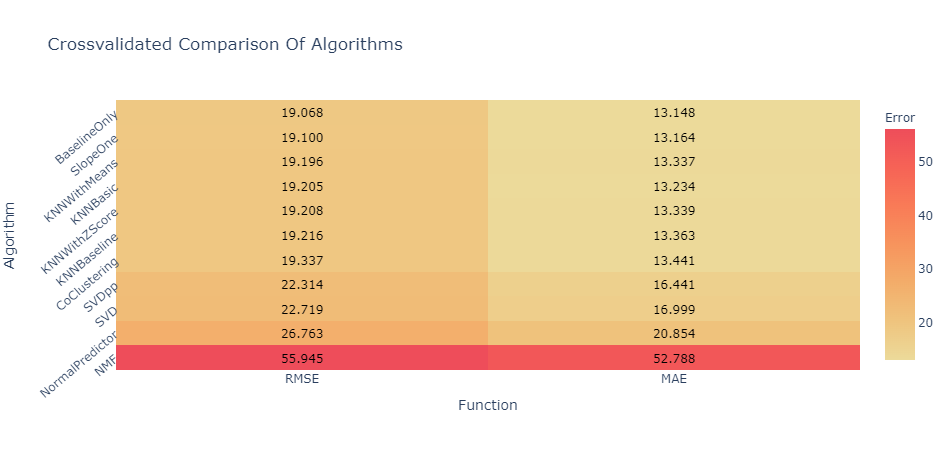

In [65]:
# Store results
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse', ascending=False)

# Get data
data = surprise_results[['test_rmse', 'test_mae']]
grid = data.values

# Create axis labels
x_axis = [label.split('_')[1].upper() for label in data.columns.tolist()]
y_axis = data.index.tolist()

x_label = 'Function'
y_label = 'Algorithm'


# Get annotations and hovertext
hovertexts = []
annotations = []
for i, y_value in enumerate(y_axis):
    row = []
    for j, x_value in enumerate(x_axis):
        annotation = grid[i, j]
        row.append('Error: {:.3f}<br>{}: {}<br>{}: {}<br>Fit Time: {:.3f}s<br>Test Time: {:.3f}s'.format(annotation, y_label, y_value ,x_label, x_value, surprise_results.loc[y_value]['fit_time'], surprise_results.loc[y_value]['test_time']))
        annotations.append(dict(x=x_value, y=y_value, text='{:.3f}'.format(annotation), ax=0, ay=0, font=dict(color='#000000')))
    hovertexts.append(row)

# Create trace
trace = go.Heatmap(x = x_axis,
                   y = y_axis,
                   z = data.values,
                   text = hovertexts,
                   hoverinfo = 'text',
                   colorscale = 'oryel',
                   colorbar = dict(title = 'Error'))

# Create layout
layout = go.Layout(title = 'Crossvalidated Comparison Of Algorithms',
                   xaxis = dict(title = x_label),
                   yaxis = dict(title = y_label,
                                tickangle = -40),
                   annotations = annotations)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)